In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import numpy as np
import pandas as pd
import ast
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

In [3]:
csv_path = "yoga_keypoints_with_angles.csv"  
df = pd.read_csv(csv_path)

In [4]:
keypoint_columns = df.columns[2:134]  # 132 values (33 keypoints * 4)
angle_columns = df.columns[134:142]  
label_column = 'class_label'

In [5]:
def parse_tuple(value):
    try:
        return list(ast.literal_eval(value))  
    except:
        return [0, 0, 0, 0]  

for col in keypoint_columns:
    df[col] = df[col].apply(parse_tuple)

In [6]:
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df[label_column])

In [7]:
X = []
for i, row in df.iterrows():
    keypoints_flat = np.array([item for sublist in row[keypoint_columns] for item in sublist], dtype=np.float32)
    angles = np.array(row[angle_columns], dtype=np.float32)
    X.append(np.concatenate([keypoints_flat, angles]))

X = np.array(X, dtype=np.float32)
y = df['encoded_label'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, "scaler_mlp.pkl")

['scaler_mlp.pkl']

In [19]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),

    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

c:\Users\raksh\OneDrive\Desktop\Mv_Project\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, decay=1e-6), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
callbacks_list = [ callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6), callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]

c:\Users\raksh\OneDrive\Desktop\Mv_Project\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [21]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=callbacks_list)
model.save("model_MLP.h5")

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0234 - loss: 4.6145 - val_accuracy: 0.1282 - val_loss: 4.1437 - learning_rate: 0.0010
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1074 - loss: 4.0105 - val_accuracy: 0.2397 - val_loss: 3.2881 - learning_rate: 0.0010
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1988 - loss: 3.3233 - val_accuracy: 0.3513 - val_loss: 2.6578 - learning_rate: 0.0010
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2793 - loss: 2.8060 - val_accuracy: 0.4384 - val_loss: 2.1996 - learning_rate: 0.0010
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3230 - loss: 2.4991 - val_accuracy: 0.4677 - val_loss: 1.9102 - learning_rate: 0.0010
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3835 - loss: 2.2141 - val_accuracy: 0.5068 - val_loss: 1.7562 - learning_rate: 0.0010
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4229 - loss: 2

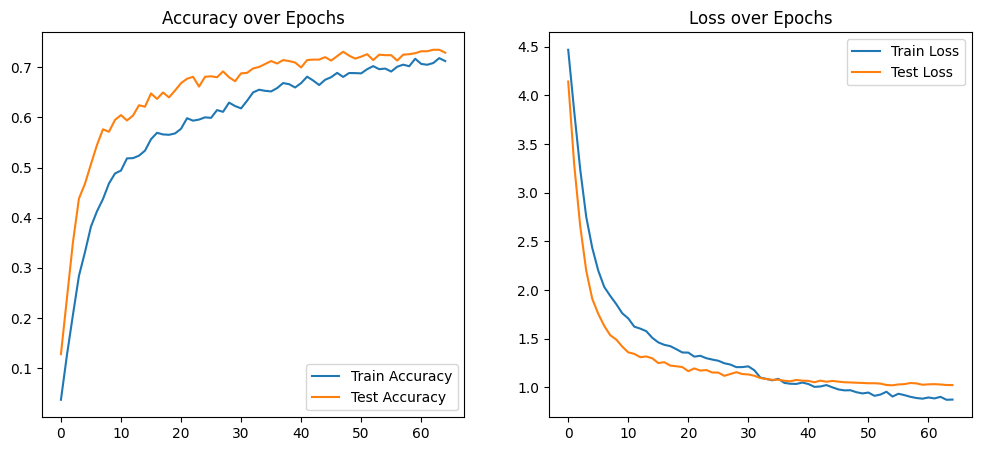

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.title("Loss over Epochs")

plt.show()